In [ ]:
import re
import time
import pandas as pd

In [ ]:
# load csv from data/mask_human/gen_80000_tests/diff_steps.csv without index column
df = pd.read_csv('data/mask_human/gen_80000_tests/diff_steps_2000_ids.csv')

In [ ]:
df

In [ ]:
# print all tgt-gen pairs when steps == 3999
for i, row in df[df['step'] == 1999].iterrows():
    print(row['tgt'])
    print(row['gen'])
    print()

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [115]:
# tgt = "- stir in flour and salt. cook over low heat, stirring constantly, about 1 minute. remove from heat. stir in chicken broth and water. - heat to a boil, stirring constantly. boil and stir 1 minute. stir in half and half and sliced mushrooms. - garnish with parsley"
# gen = "stir in flour and salt. add chicken broth, water, and mix well. - stir into mushrooms and heat until vegetables are tender. - add half and half and mix well. - remove from heat. stir well. sprinkle parsley."
# tgt="- refrigeratetill slightly thickened, beat till frothy and mix in cold whip. - mix in cake broken in pcs. - put into 9 x 13 inch pan and chill."
# gen = "- add in cold whip. - cook and freeze 1 hour in mixture. - pour into remaining jello. - serve with 1 angle food cake."
tgt="- finely mince the fresh basil leaves. - sprinkle over the greens. - cover and chill until ready to serve."
gen="- add the leaves, fresh and chopped basil. - add the bowl of bowl, whipping cream and lemon juice. - stir well and season with salt and pepper. - serve with salad."

In [116]:
# dictionary of words in the final generated text, that will be followed throughout generation
# words_to_follow = ["stir", "in", "flour", "and", "salt", "into", "mushrooms"]
words_to_follow = ["."] + list(set([re.sub("\.|,|-","",w) for w in gen.split(" ") if len(re.sub("\.|,|-","",w))>1]))
w2id = {w: tokenizer.encode(w, add_special_tokens=False)[0] for w in words_to_follow}
w2id["."] = 0
w2id

{'.': 0,
 'basil': 14732,
 'well': 2092,
 'lemon': 14380,
 'fresh': 4840,
 'the': 1996,
 'season': 2161,
 'salt': 5474,
 'bowl': 4605,
 'add': 5587,
 'serve': 3710,
 'whipping': 23016,
 'and': 1998,
 'with': 2007,
 'salad': 16521,
 'juice': 10869,
 'leaves': 3727,
 'pepper': 11565,
 'of': 1997,
 'cream': 6949,
 'stir': 16130,
 'chopped': 24881}

In [117]:
# get all the partial generations from the sample we are investigating
diffusion_ids = df[df["tgt"]==tgt]["ids"].to_list()

In [118]:
df[df["tgt"]==tgt].iloc[1406]["gen"]

'- beatingᵉ₅, [unused571] and chopped [unused816]金 - add the tea″口ட [unused642]相 greenս juice. [unused592] lady [unused362]ᵉ season ю ‿月 pepper.⽥ [unused239] withಾ.'

In [119]:
# clean those ids to only the tokens we care about (the ones in the final generation) and 0 otherwise

def id_is_in_words_to_follow(i, w2id):
    return i in w2id.values()

ids_clean = []
for d in diffusion_ids:
    # parse list from string
    d = d[1:-1].split(", ")
    d = [int(i) if int(i) in w2id.values() else 0 for i in d]
    ids_clean.append(d)
    

In [120]:
# list of 20 colors by string that plt understands
colors = [
    'white','red', 'blue', 'green', 'purple', 'orange', 'cyan', 'brown', 'pink', 'gray', 'olive',
    '#FF5733', '#3399FF', '#33FF57', '#9933FF', '#FFA500', '#00FFFF', '#A52A2A', '#FFC0CB', '#808080', '#808000',
    'salmon', 'dodgerblue', 'limegreen', 'darkorchid', 'darkorange', 'lightseagreen', 'saddlebrown', 'hotpink', 'dimgray', 'darkolivegreen'
]
colors = [
    'white','#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',
    '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#ff5733', '#3399FF', '#33FF57', '#9933FF', '#FFA500',
    '#00FFFF', '#A52A2A', '#FFC0CB', '#808080', '#808000',
    '#FF1493', '#000080', '#008080', '#800080', '#FFD700',
    '#00FF00', '#0000FF', '#FF4500', '#8B4513', '#800000'
]
colors_dict={i: colors[i] for i, w in enumerate(w2id)}

In [121]:
# dictionary from token id to id in the plot (so that the colours in the plot work well)
id2plot = {v: i for i, v in enumerate(w2id.values())}
id2plot

{0: 0,
 14732: 1,
 2092: 2,
 14380: 3,
 4840: 4,
 1996: 5,
 2161: 6,
 5474: 7,
 4605: 8,
 5587: 9,
 3710: 10,
 23016: 11,
 1998: 12,
 2007: 13,
 16521: 14,
 10869: 15,
 3727: 16,
 11565: 17,
 1997: 18,
 6949: 19,
 16130: 20,
 24881: 21}

In [122]:
for v in ids_clean[75:95]:
    for i in v:
        if i != 0:
            print(i, end=" ")

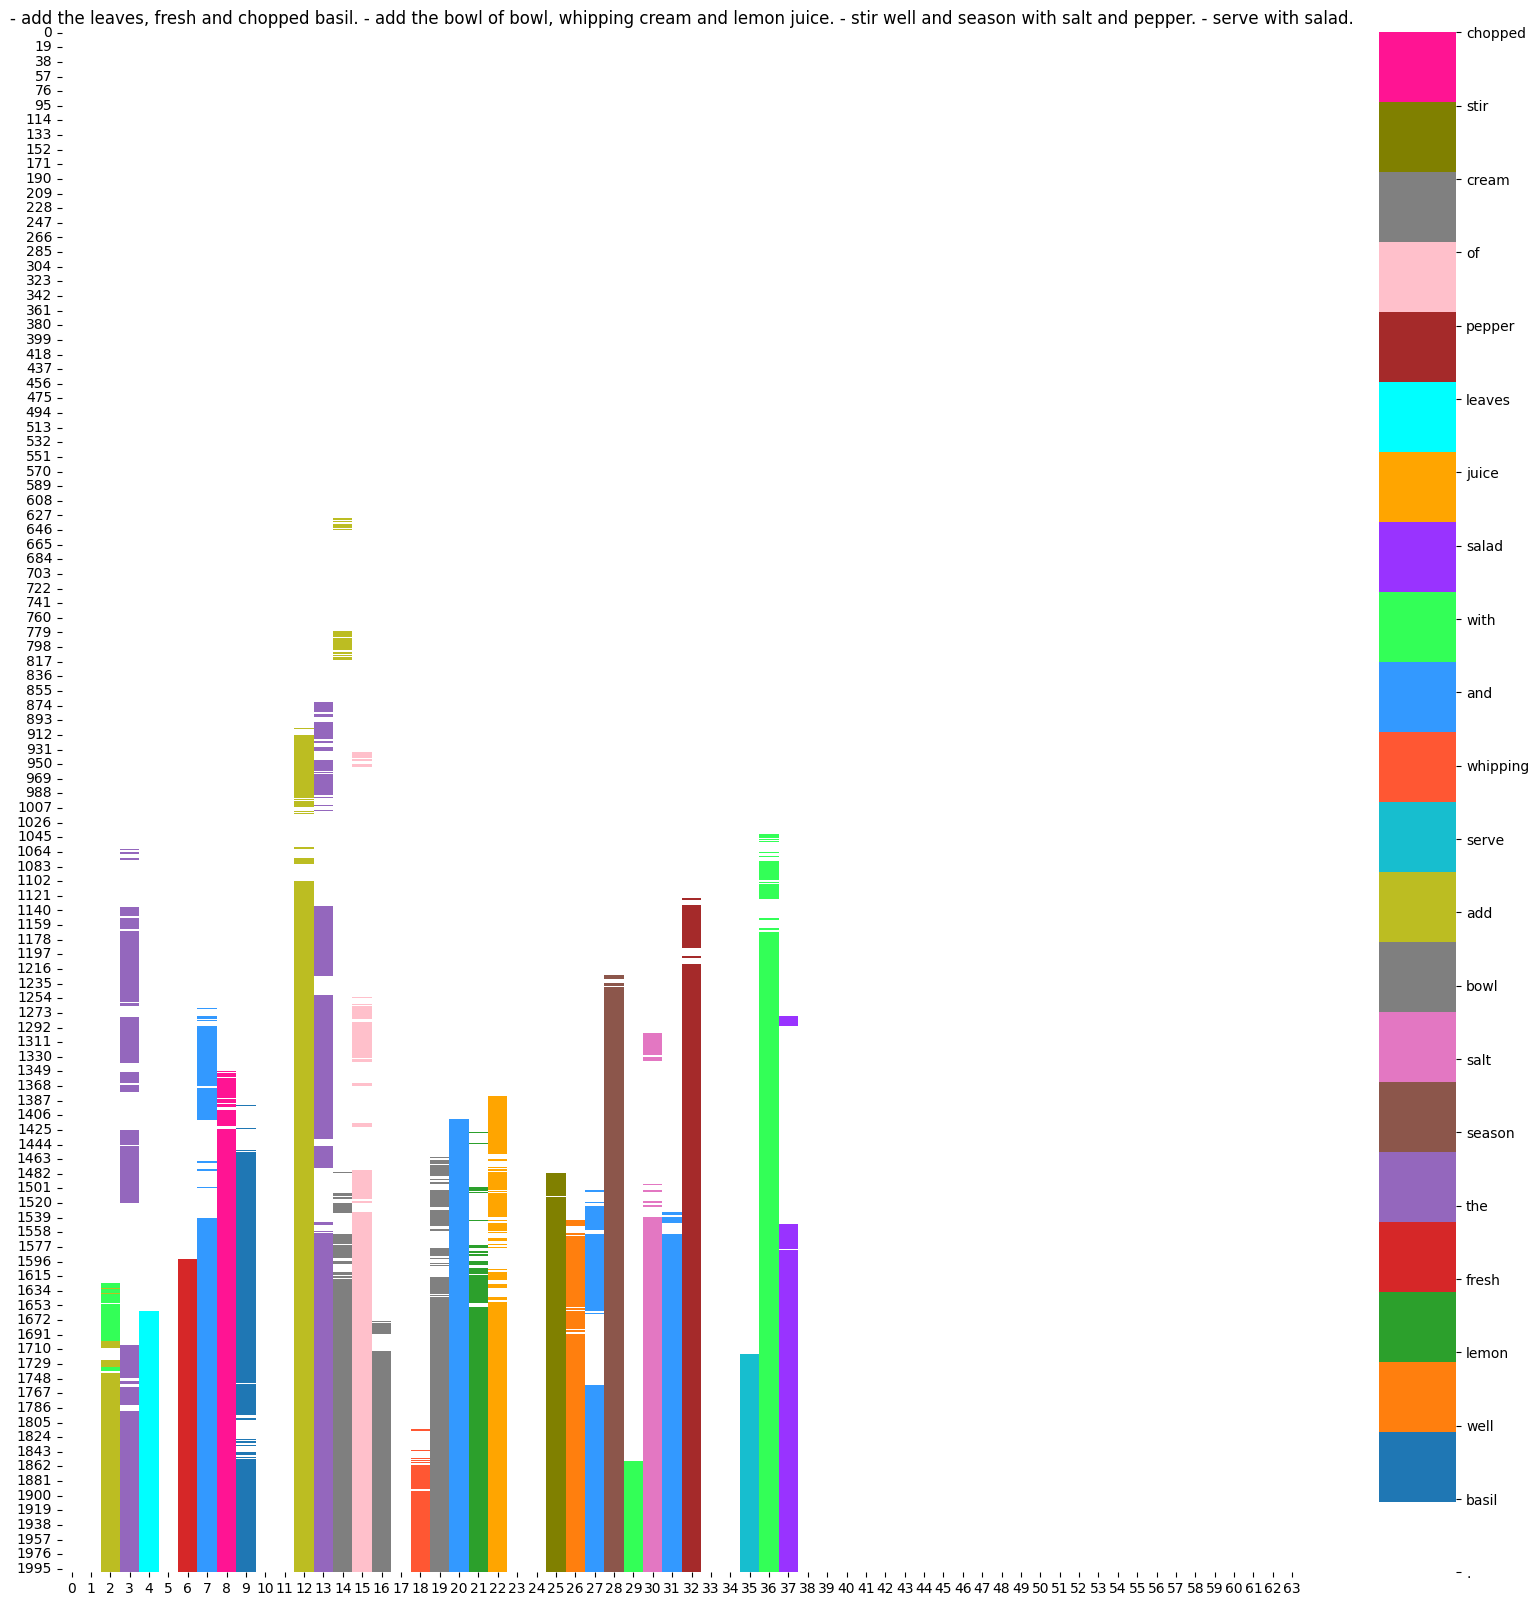

In [123]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
matrix = ids_clean
# from ids_clean to id2plot
plt.figure(figsize=(20, 20))

matrix = [[id2plot[i] for i in row] for row in matrix]

cmap = mcolors.ListedColormap([colors_dict[key] for key in colors_dict.keys()])
hm = sns.heatmap(matrix, cmap=cmap)
# title the hm to the gen sentence
hm.set_title(gen)

colorbar = hm.collections[0].colorbar
# set tick labels to the amount of words, equidistant
colorbar.set_ticks([i for i in range(len(w2id))])
colorbar.set_ticklabels(words_to_follow)

plt.show()


INFO:absl:Using default tokenizer.


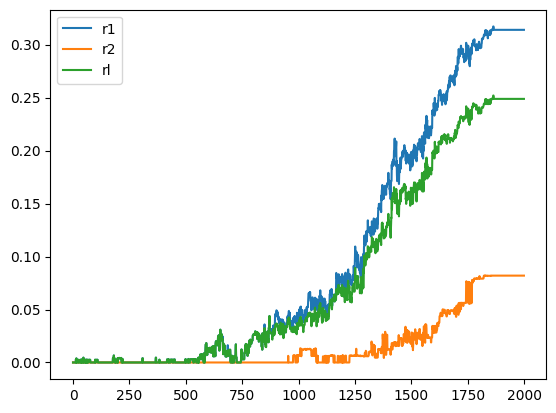

In [124]:
import evaluate

rouge = evaluate.load('rouge')
rouge_scores = rouge.compute(
    predictions = list(df['gen']),
    references = list(df['tgt']),
    use_aggregator=False,
)
df["r1"] = rouge_scores["rouge1"]
df["r2"] = rouge_scores["rouge2"]
df["rl"] = rouge_scores["rougeL"]
# plot steps vs r1, r2, rl
# drop all other columns
df2 = df.drop(columns=['gen', 'tgt', 'src',"ids"])
# group by steps and get mean of r1, r2, rl
df2 = df2.groupby('step').mean().reset_index()
plt.plot(df2['step'], df2['r1'], label='r1')
plt.plot(df2['step'], df2['r2'], label='r2')
plt.plot(df2['step'], df2['rl'], label='rl')
plt.legend()
plt.show()

In [ ]:
import nltk

# Download the NLTK data for POS tagging
nltk.download('averaged_perceptron_tagger')

# Sample sentence
sentence = "This is a sample sentence."

# Tokenize the sentence into words
words = nltk.word_tokenize(sentence)

# Perform POS tagging
pos_tags = nltk.pos_tag(words)

# Print the POS tags for each word
print(pos_tags)

In [125]:
# get all post tags:
# Get all POS tags
tokens = [tokenizer.convert_ids_to_tokens(i) for i in ids_clean]
pos_tags = set(tag for word, tag in nltk.pos_tag([t for seq in tokens for t in seq]))
# Assign integers to POS tags
pos_tag_dict = {tag: i + 1 for i, tag in enumerate(sorted(pos_tags))}
pos_tag_dict

{'CC': 1,
 'DT': 2,
 'IN': 3,
 'JJ': 4,
 'NN': 5,
 'NNP': 6,
 'NNS': 7,
 'RB': 8,
 'VB': 9,
 'VBD': 10,
 'VBG': 11,
 'VBP': 12,
 'VBZ': 13}

In [129]:
pos_tag_dict = {'CC': 1,
 'IN': 2,
 'JJ': 3,
 'NN': 4,
 'RB': 5,
 'VB': 6,
 "DT":7
 }

In [130]:
tags_matrix = []
for seq in ids_clean:
    tags = nltk.pos_tag([tokenizer.decode(t) for t in seq])
    partial = []
    for t in tags:
        if t[0] == "[PAD]":
            partial.append(0)
        else:
            if "stir" in t[0]:
                partial.append(pos_tag_dict["VB"])
            elif "NN" in t[1]:
                partial.append(pos_tag_dict["NN"])
            elif "VB" in t[1]:
                partial.append(pos_tag_dict["VB"])
            else:
                partial.append(pos_tag_dict[t[1]])
    tags_matrix.append(partial)

In [ ]:
# seq = ids_clean[-1]
# tags = nltk.pos_tag([tokenizer.decode(t) for t in seq])
# partial = []
# for t in tags:
#     if t[0] == "[PAD]":
#         partial.append(0)
#     else:
#         if "stir" in t[0]:
#             partial.append(pos_tag_dict["VB"])
#         elif "NN" in t[1]:
#             partial.append(pos_tag_dict["NN"])
#         elif "VB" in t[1]:
#             partial.append(pos_tag_dict["VB"])
#         else:
#             partial.append(pos_tag_dict[t[1]])
# partial

In [ ]:
# tags_matrix = []
# for seq in pos_tags:
#     partial = []
#     for s in seq:
#         if s[0] == "[PAD]":
#             partial.append(0)
#         else:
#             partial.append(pos_tag_dict[s[1]])
#     tags_matrix.append(partial)


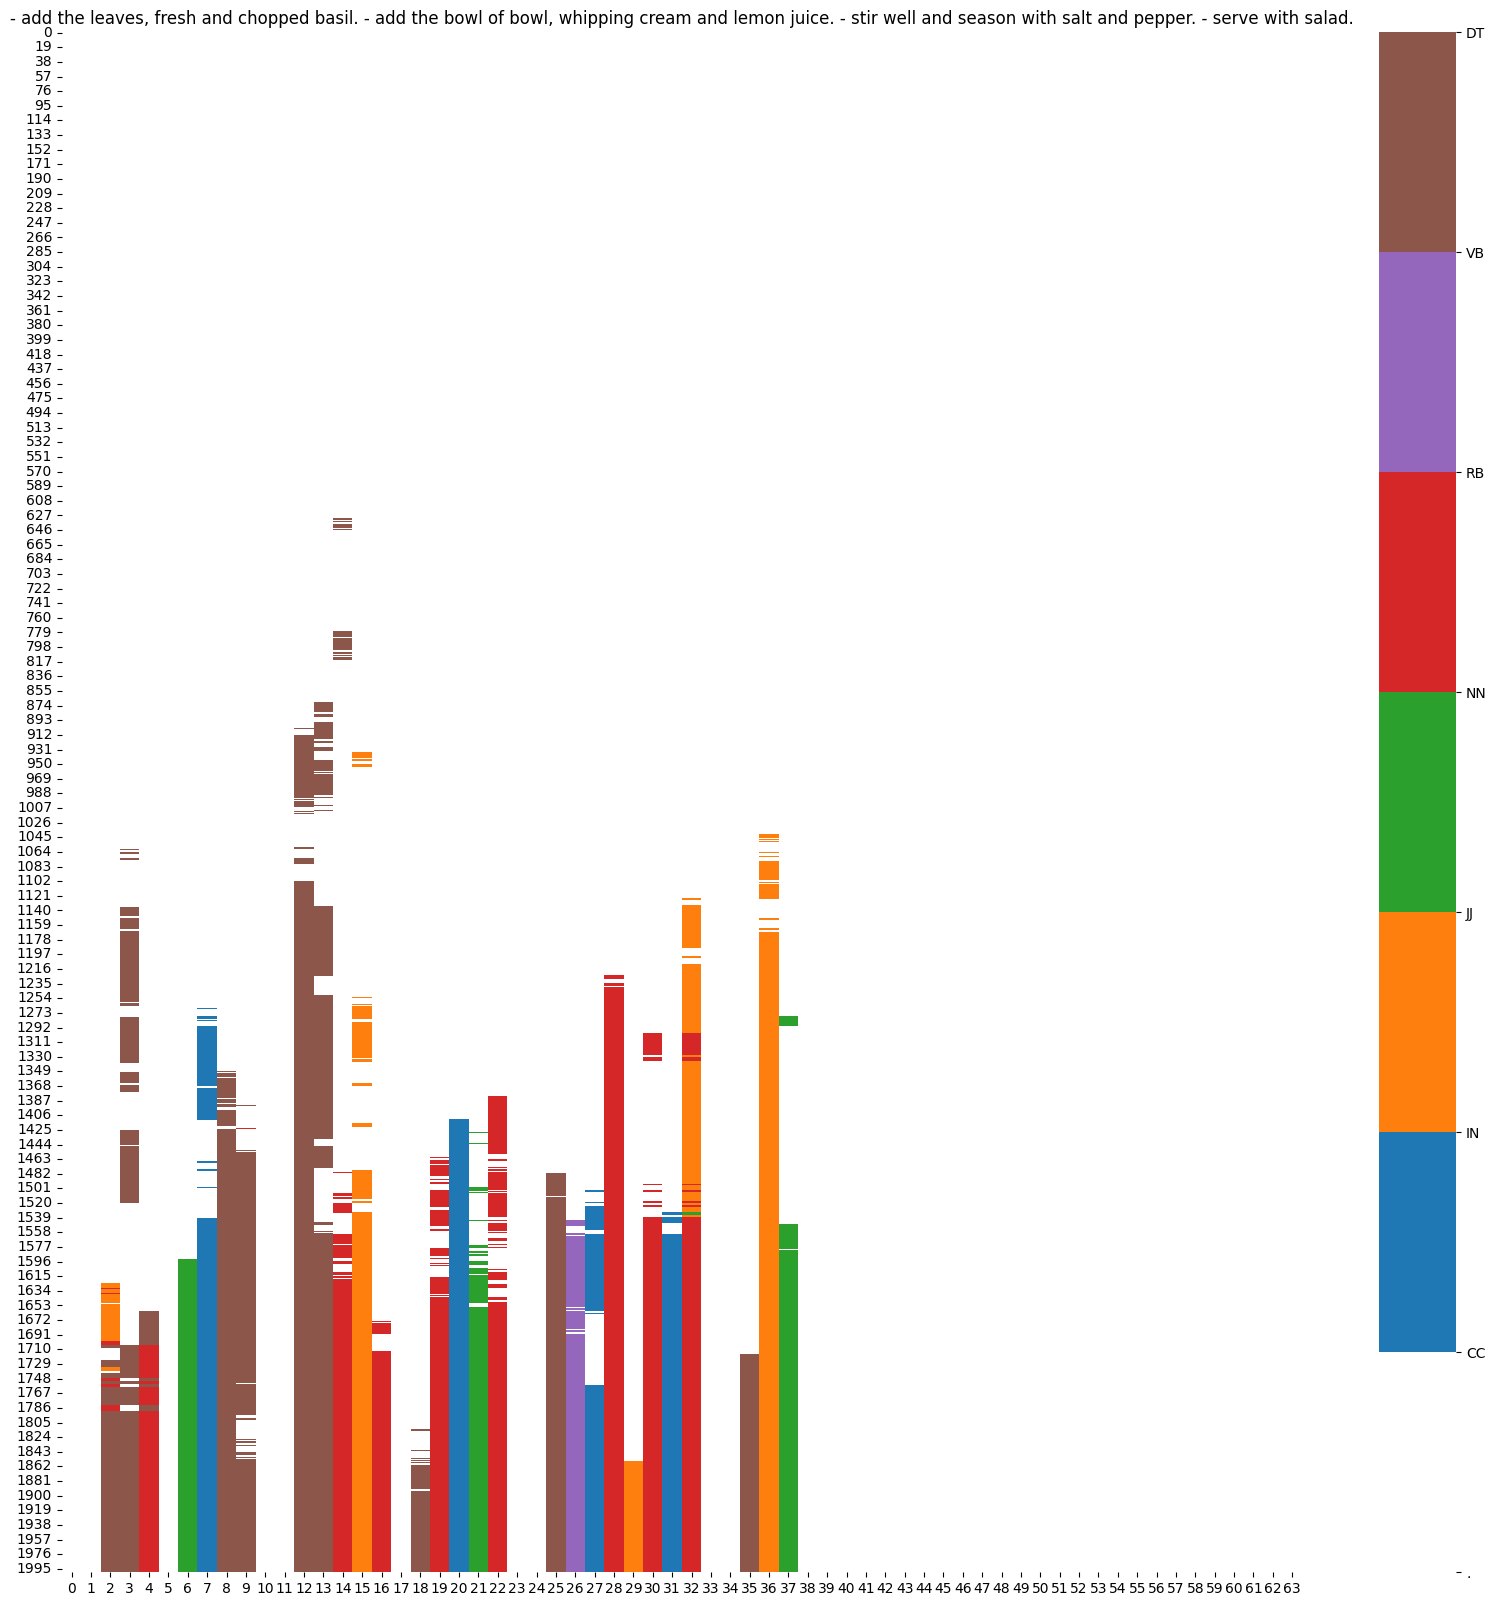

In [131]:
matrix = tags_matrix
colors_dict={i: colors[i] for i, w in enumerate(pos_tag_dict)}
# from ids_clean to id2plot
plt.figure(figsize=(20, 20))

# matrix = [[id2plot[i] for i in row] for row in matrix]

cmap = mcolors.ListedColormap([colors_dict[key] for key in colors_dict.keys()])
hm = sns.heatmap(matrix, cmap=cmap)
# title the hm to the gen sentence
hm.set_title(gen)

colorbar = hm.collections[0].colorbar
# set tick labels to the amount of words, equidistant
colorbar.set_ticks([i for i in range(len(pos_tag_dict)+1)])
colorbar.set_ticklabels(["."]+list(pos_tag_dict.keys()))

plt.show()